Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 271s 5ms/step - loss: 1.9425 - acc: 0.3046 - val_loss: 1.5698 - val_acc: 0.4345
Epoch 2/5
50000/50000 [==============================] - 244s 5ms/step - loss: 1.5723 - acc: 0.4250 - val_loss: 2.3279 - val_acc: 0.3023
Epoch 3/5
50000/50000 [==============================] - 244s 5ms/step - loss: 1.4365 - acc: 0.4800 - val_loss: 1.2760 - val_acc: 0.5398
Epoch 4/5
50000/50000 [==============================] - 244s 5ms/step - loss: 1.3239 - acc: 0.5223 - val_loss: 1.4139 - val_acc: 0.4779
Epoch 5/5
50000/50000 [==============================] - 243s 5ms/step - loss: 1.2448 - acc: 0.5532 - val_loss: 1.1851 - val_acc: 0.5799
-------------------------------------------------
Classification accuracy on the test set:0.5799
-------------------------------------------------

-------------------------------------------------
Cross Entropy Error Curves for Train and Test data
----------------

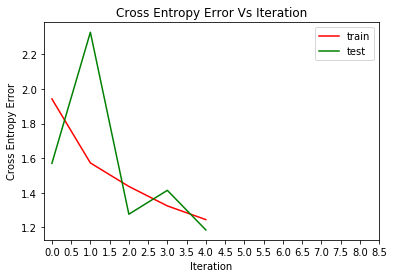

-------------------------------------------------
Showing first 5 filters from 1st and 2nd Convolutional layers
-------------------------------------------------


<Figure size 576x432 with 0 Axes>

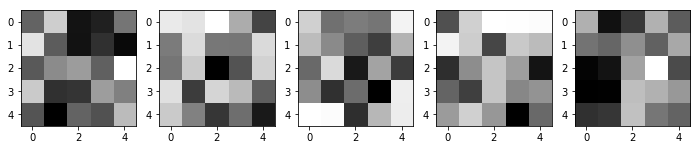

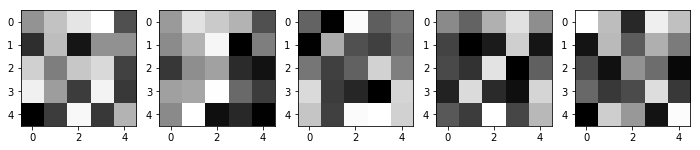

In [4]:
'''--------------Importing Libraries--------------'''
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from keras.utils import np_utils
import pickle
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
import matplotlib.pyplot as plt

'''--------------Defining Functions--------------'''
def get_unpickled(data_dir, file_name):
   
    with open(data_dir + file_name,'rb') as fo:
        cifar_dict = pickle.load(fo, encoding='bytes')
    return cifar_dict


def get_normalize(x):
    
    min_val = np.min(x)
    max_val = np.max(x)
    x = (x-min_val) / (max_val-min_val)
    return x


def get_onehotencode(x, num_classes):
    
    arr = np.zeros((len(x), num_classes))
    
    for i, val in enumerate(x):
        arr[i][val] = 1
    
    return arr

def get_preprocessed_data(data, num_channel, size):
    data_set = data
    img_data = data_set[b'data']
    img = np.array(img_data, dtype = float) / 255.0
    pro_img = img.reshape([-1, num_channel, size, size]).transpose([0, 2, 3, 1])
    images = get_normalize(pro_img)
    
    img_labels = np.array(data[b'labels'])
    img_onehotencode = get_onehotencode(img_labels, num_classes)

    return images, img_labels, img_onehotencode
    
def get_test_img(data_dir, num_channel, size):
    data = get_unpickled(data_dir,"test_batch")
    img, class_name, onehotencode = get_preprocessed_data(data, num_channel, size)
    #print(len(img))
    return img, class_name, onehotencode

def get_train_img(data_dir, num_channel, size, num_classes):
    train_dirs = ['data_batch_1','data_batch_2','data_batch_3','data_batch_4','data_batch_5']
    train_dataset=[]
    for i in range(len(train_dirs)):
        train_dataset.append(get_unpickled(data_dir,train_dirs[i]))    
    data = np.vstack([i[b'data'] for i in train_dataset])
    
    data_img = np.array(data, dtype = float) / 255.0
    pro_img=  data_img.reshape([-1, num_channel, size, size]).transpose([0, 2, 3, 1])
    images = get_normalize(pro_img)
    img_labels = np.hstack([i[b'labels'] for i in train_dataset])
    img_onehotencode = get_onehotencode(img_labels, num_classes)
    #print(len(images))
    
    return images, img_labels, img_onehotencode

    
    

'''------------Main Program-------------'''

data_dir = 'cifar-10-batches-py/'
size=32
num_classes=10
num_channel=3
num_train_batches=5
num_img_per_batch=10000
total_num_train_img=num_train_batches*num_img_per_batch
max_epos=5

test_img, test_class, test_encode= get_test_img(data_dir, num_channel, size)

train_img, train_class, train_encode= get_train_img(data_dir, num_channel, size,num_classes)

#print(test_encode)


'''-----------The CNN-----------------'''
model = Sequential()    

model.add(Conv2D(64, (5, 5), activation='relu', padding='same', input_shape=(size,size,num_channel)))  
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(BatchNormalization(axis=-1))
  
model.add(Conv2D(64, (5, 5), activation='relu')) 
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(BatchNormalization(axis=-1))  

model.add(Flatten())

model.add(Dense(382))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(192))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(10))
model.add(Activation('softmax')) 

opt_sgd = keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)

model.compile(loss='categorical_crossentropy',optimizer=opt_sgd, metrics=['accuracy'])

cnn = model.fit(train_img, train_encode, batch_size=50, epochs=max_epos, validation_data=(test_img,test_encode),shuffle=True)

performance = model.evaluate(test_img, test_encode, verbose=0)
print("-------------------------------------------------")
print("Classification accuracy on the test set:"+str(performance[1]))
print("-------------------------------------------------")
print("")
print("-------------------------------------------------")
print("Cross Entropy Error Curves for Train and Test data")
print("-------------------------------------------------")
plt.figure(1)
plt.plot(cnn.history['loss'],'r')
plt.plot(cnn.history['val_loss'],'g')
plt.xticks(np.arange(0, 9, 0.5))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Iteration")
plt.ylabel("Cross Entropy Error")
plt.title("Cross Entropy Error Vs Iteration")
plt.legend(['train','test'])

plt.show()
print("-------------------------------------------------")
print("Showing first 5 filters from 1st and 2nd Convolutional layers")
print("-------------------------------------------------")

conv_layer_1 = model.layers[0].get_weights()[0][:,:,0,:]

conv_layer_2 = model.layers[3].get_weights()[0][:,:,0,:]

col = 5
#row = 1
#filter_index = 0
plt.figure(2)

#------1st Convolutional Layer-----------
fig = plt.figure(figsize=(12,8))
for i in range(0, col):
    ax = fig.add_subplot(1,5,i+1)
    ax.imshow(conv_layer_1[:,:,i], cmap='gray')    
#-------2nd Convolutional Layer---------    
fig = plt.figure(figsize=(12,8))
for i in range(0, col):
    ax = fig.add_subplot(2,5,i+1)
    ax.imshow(conv_layer_2[:,:,i], cmap='gray')     
plt.show()
 


**Goal 1** Using 5 max iteration I have attained accuracy as 0.56

**Goal 2** Cross entropy error curve for testing data and training data is shown by plot. From this plot it is clear that the error is decreasing with the number of iteration for both training and test data.

**Goal 3** The filters for 1st convolutional layer and 2nd convolutional layer is shown in a plot